##### Model in which 1st model is a skewed gaussian and 2nd peak is a gaussian

In [1]:
import os

# Change working directory to the BAYES folder
os.chdir(r'C:\Users\solom\Desktop\BAYES')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy import optimize
import scipy
import bayesian_model as bm
import plotting
import emcee
import math
import corner

# Load the data
data = pd.read_csv('C:/Users/solom/Desktop/BAYES/dielectron.csv')

data = data.dropna()
data = data[(data['Q1'] + data['Q2']) == 0]

path = 'C:/Users/solom/Desktop/BAYES/'
path_plots = 'C:/Users/solom/Desktop/BAYES/Plots/'

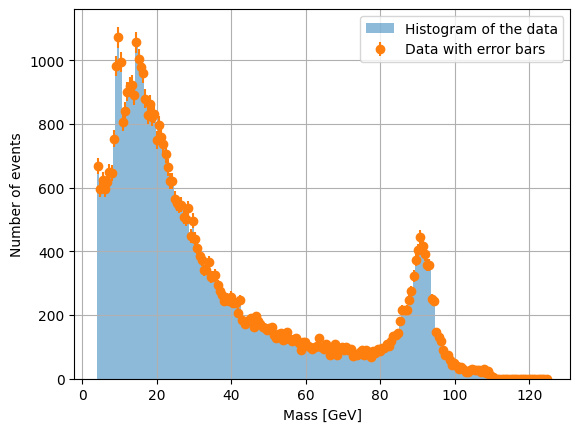

In [3]:
M_data = data['M'].values
#plt.hist(M_data, bins=200, range=(4, 125), alpha=0.5, label='Data')

y, bins, _ = plt.hist(M_data, bins=200, range=(4,125), alpha=0.5, label='Histogram of the data')
x = 0.5*(bins[1:]+bins[:-1])
y_errors = np.sqrt(y)  # Assuming Poisson statistics for the errors ----MAYBE ASK ABOUT THIS----

plt.errorbar(x, y, yerr=y_errors, fmt='o', label='Data with error bars')

plt.grid()
plt.xlabel('Mass [GeV]')
plt.ylabel('Number of events')

plt.legend()
plt.show()

counts = y
energies = x
counts_err = y_errors

In [4]:
def background(x,b,k):
    return b * np.exp(-k*x)

def gauss_peak(x, a, mu, sigma):
    return a * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def skewed_gaussian_peak(x, a, mu, sigma, s):
    return stats.skewnorm.pdf(x, a=s, loc=mu, scale=sigma)*a

def model_skewed(x, a1, mu1, sigma1, s1, a2, mu2, sigma2, b, k):
    return skewed_gaussian_peak(x, a1, mu1, sigma1, s1) + gauss_peak(x, a2, mu2, sigma2) + background(x, b, k)

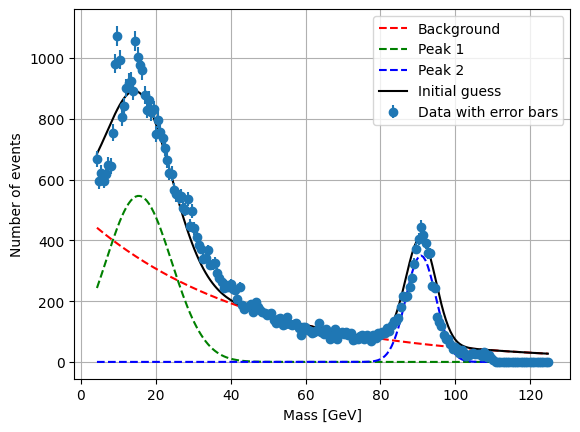

In [5]:
a1 = 12e3
mu1 = 17.5
sigma1 = 9
s = -0.3
a2 = 3.5e2
mu2 = 9.08079297e+01
sigma2 = 4
b = 4.87892161e+02
k = 2.31631922e-02

pars = np.array([a1, mu1, sigma1, s, a2, mu2, sigma2, b, k])
x = energies



plt.plot(x, background(x, b, k), label='Background', color = 'red', linestyle='--')
plt.plot(x, skewed_gaussian_peak(x, a1, mu1, sigma1, s), label='Peak 1', color = 'green', linestyle='--')
plt.plot(x, gauss_peak(x, a2, mu2, sigma2), label='Peak 2', color = 'blue', linestyle='--')
plt.plot(x, model_skewed(x, pars[1-1], pars[2-1], pars[3-1],pars[4-1], pars[5-1], pars[6-1], pars[7-1], pars[8-1], pars[9-1] ), label='Initial guess', color = 'black')



plt.errorbar(x, y, yerr=y_errors, fmt='o', label='Data with error bars')
plt.grid()
plt.xlabel('Mass [GeV]')
plt.ylabel('Number of events')
plt.legend()
plt.show()

In [6]:


print('Initial guess: ', pars)
print('Sigma: ',pars * 0.3)

Initial guess:  [ 1.20000000e+04  1.75000000e+01  9.00000000e+00 -3.00000000e-01
  3.50000000e+02  9.08079297e+01  4.00000000e+00  4.87892161e+02
  2.31631922e-02]
Sigma:  [ 3.60000000e+03  5.25000000e+00  2.70000000e+00 -9.00000000e-02
  1.05000000e+02  2.72423789e+01  1.20000000e+00  1.46367648e+02
  6.94895766e-03]


In [7]:
sig = 0.2

myclip_a = 0
myclip_b = np.inf

my_mean1 = pars[2]
my_std1 = pars[2]*sig
a1, b1 = (myclip_a - my_mean1) / my_std1, (myclip_b - my_mean1) / my_std1

my_mean2 = pars[6]
my_std2 = pars[6]*sig
a2, b2 = (myclip_a - my_mean2) / my_std2, (myclip_b - my_mean2) / my_std2

my_mean3 = pars[8]
my_std3 = pars[8]*sig
a3, b3 = (myclip_a - my_mean3) / my_std3, (myclip_b - my_mean3) / my_std3

a1_prior = scipy.stats.norm(loc=pars[0], scale=pars[0]*sig)
mu1_prior = scipy.stats.norm(loc=pars[1], scale=pars[1]*sig)
sigma1_prior = scipy.stats.truncnorm(a1, b1, loc=pars[2], scale=pars[2]*sig)
s_prior = scipy.stats.norm(loc=pars[3], scale=-pars[3]*sig)

a2_prior = scipy.stats.norm(loc=pars[4], scale=pars[4]*sig)
mu2_prior = scipy.stats.norm(loc=pars[5], scale=pars[5]*sig)
sigma2_prior = scipy.stats.truncnorm(a2, b2, loc=pars[6], scale=pars[6]*sig)

b_prior = scipy.stats.norm(loc=pars[7], scale=pars[7]*sig)
k_prior = scipy.stats.truncnorm(a3, b3, loc=pars[8], scale=pars[8]*sig)

priors = [a1_prior, mu1_prior, sigma1_prior, s_prior,
          a2_prior, mu2_prior, sigma2_prior, 
          b_prior, k_prior]

[[ 1.61267437e+04  1.84893111e+01  1.14531384e+01 -2.74897139e-01
   4.49423961e+02  9.22443694e+01  3.86924027e+00  5.12926899e+02
   2.59951212e-02]
 [ 6.33788463e+03  1.73349508e+01  1.00463919e+01 -3.53544380e-01
   3.27628690e+02  7.32862951e+01  4.47377810e+00  4.60325764e+02
   2.01728770e-02]
 [ 1.06287625e+04  1.96580226e+01  8.91284932e+00 -2.94556994e-01
   4.28116163e+02  9.24252801e+01  4.44116635e+00  5.82052008e+02
   2.74531661e-02]
 [ 1.26378889e+04  1.45682899e+01  6.52100157e+00 -4.33045057e-01
   3.47878764e+02  1.04953933e+02  4.36996997e+00  5.12893880e+02
   2.61504231e-02]
 [ 9.81098181e+03  2.39370316e+01  8.37222866e+00 -2.48762198e-01
   4.54406564e+02  1.13775887e+02  3.97570854e+00  4.47596523e+02
   2.06022742e-02]
 [ 1.16254598e+04  2.56055051e+01  8.95761483e+00 -2.04788007e-01
   2.52131879e+02  7.48164474e+01  3.14691875e+00  6.12526591e+02
   2.26937525e-02]
 [ 1.04669018e+04  1.67710080e+01  7.97148066e+00 -2.22127343e-01
   3.86175829e+02  9.5101430

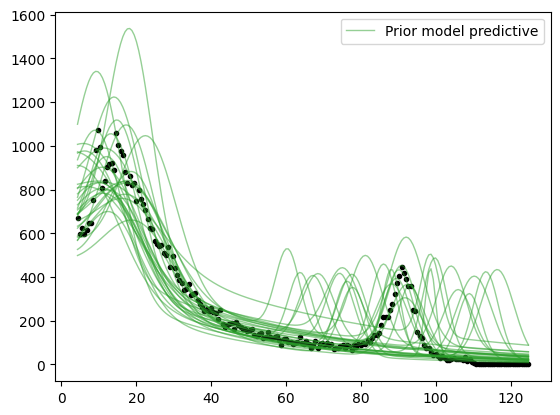

In [8]:
# Fix the pseudo random number generator seed for reproducibility
np.random.seed(3)

# Evaluate the mode3 at the prior sample parameters
prior_model_predictive = np.array(
    [model_skewed(x, *parameters) for parameters in bm.sample_prior(n_sample=30, priors=priors)]
)

print(bm.sample_prior(n_sample=30, priors=priors))

style = dict(c="C2", lw=1, alpha=0.5)
plt.plot(x, y, '.', color = 'black')
plt.plot(x, prior_model_predictive.T, **style)
plt.plot([], [], label="Prior model predictive", **style)
plt.legend()

70


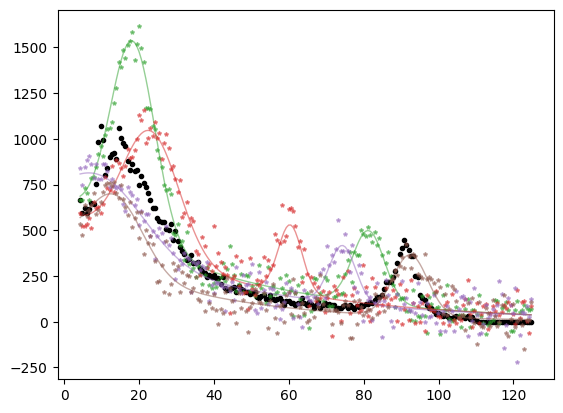

In [ ]:
sigma_y = 70
prior_predictive = (
    prior_model_predictive
    + sigma_y*np.random.normal(size=prior_model_predictive.shape)
)

pmp_style = dict(lw=1, alpha=0.5)
pp_style = dict(ls="none", marker="*", ms=3, alpha=0.5)

plt.plot(x, y, ".", color = 'black')

for i in range(4):
    plt.plot(x, prior_model_predictive[i], c=f"C{i+2}", **pmp_style)
    plt.plot(x, prior_predictive[i], c=f"C{i+2}", **pp_style)



C:\Users\solom\Desktop\Bayesian_project\lib\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
C:\Users\solom\Desktop\Bayesian_project\lib\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
C:\Users\solom\AppData\Local\Temp\ipykernel_9204\3684484018.py:2: RuntimeWarning: overflow encountered in exp
  return b * np.exp(-k*x)
C:\Users\solom\AppData\Local\Temp\ipykernel_9204\3684484018.py:2: RuntimeWarning: overflow encountered in multiply
  return b * np.exp(-k*x)


MAP results
[ 4.98149067e+04 -1.99220639e+03 -2.47429576e+03  7.26320302e-01
 -7.60685094e+03  7.01338084e+01  5.34871934e+01 -9.68424081e+03
 -3.86568905e-01]


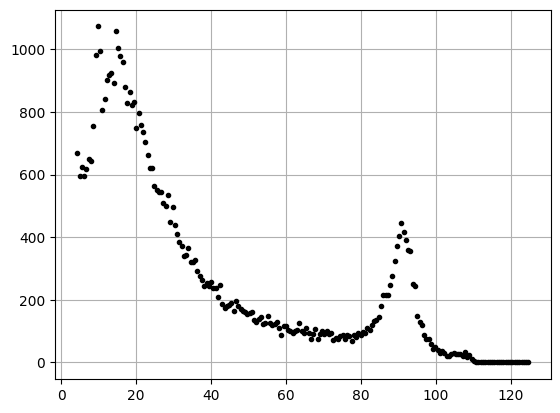

In [13]:
MAP_result = scipy.optimize.minimize(
    fun=bm.negative_log_posterior,
    x0=(a1, mu1, sigma1, s, a2, mu2, sigma2, b, k),
    args=(x, y, sigma_y, model_skewed, priors)
)
MAP_results = MAP_result.x


print("MAP results")
print(MAP_results)

plt.plot(x, y, '.', color = 'black')
plt.plot(x, model_skewed(x, *MAP_results), c="C1", label="MAP model")
plt.grid()